In [1]:
import torch
from optimize_ARPDF import ARPDFOptimizer
from ARPDF import compute_ARPDF, compare_ARPDF
from search_boxes import SimilarityCalculator
from collections import Counter
import MDAnalysis as mda
import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cupy  as cp

c:\Users\swz\anaconda3\envs\arpdf\Lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
X, Y, ARPDF_exp = utils.load_exp_data('data/CCl4', rmax=9.0)
#filter_fourier = lambda kX, kY, xp: (1 - xp.exp(-(kX**2 / 0.3 + kY**2 / 0.1)))**3 * xp.exp(-0.08 * (kX**2 + kY**2))
filter_fourier = lambda kX, kY, xp: (1 - xp.exp(-(kX**2 / 0.3 + kY**2 / 0.15))) * xp.exp(-0.045 * (kX**2 + kY**2))
#filter_fourier = lambda kX, kY, xp: 1
dir_name = "test/structure_555/"
u1 = mda.Universe(f'tmp/{dir_name}/CCl4.gro')
u2 = mda.Universe(f'tmp/{dir_name}/CCl4_optimized.gro')
modified_atoms = [690,691,692,693,694]
polar_axis = [-0.7150240546479941,0.17737067282601887,0.6762249963554939]
#u1, u2, modified_atoms, polar_axis = utils.load_structure_data(f'tmp/{dir_name}')
ARPDF = compute_ARPDF(u1, u2, cutoff=10.0, N=512, grids_XY=(X, Y), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, filter_fourier=filter_fourier, verbose=False)
sim_calculator = SimilarityCalculator(X, Y, weight_cutoff=5.0, metric='angular_scale')
sim_value = sim_calculator.calc_similarity(ARPDF, ARPDF_exp)
fig = compare_ARPDF(ARPDF, ARPDF_exp, (X, Y), sim_name="Angular Scale Sim", sim_value=sim_value, show_range=8.0, weight_cutoff=5.0)

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/test/structure_555//CCl4.gro'

In [ ]:
X, Y, ARPDF_exp = utils.load_exp_data('data/CCl4', rmax=9.0)
#filter_fourier = lambda kX, kY, xp: (1 - xp.exp(-(kX**2 / 0.3 + kY**2 / 0.1)))**3 * xp.exp(-0.08 * (kX**2 + kY**2))
#filter_fourier = lambda kX, kY, xp: (1 - xp.exp(-(kX**2 / 0.3 + kY**2 / 0.15))) * xp.exp(-0.045 * (kX**2 + kY**2))
filter_fourier = lambda kX, kY, xp: 1
dir_name = "test/structure_555/"
u1, u2, modified_atoms, polar_axis = utils.load_structure_data(f'tmp/{dir_name}')
ARPDF = compute_ARPDF(u1, u2, cutoff=10.0, N=512, grids_XY=(X, Y), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, filter_fourier=filter_fourier, verbose=False)
sim_calculator = SimilarityCalculator(X, Y, weight_cutoff=5.0, metric='angular_scale')
sim_value = sim_calculator.calc_similarity(ARPDF, ARPDF_exp)
fig = compare_ARPDF(ARPDF, ARPDF_exp, (X, Y), sim_name="Angular Scale Sim", sim_value=sim_value, show_range=8.0, weight_cutoff=5.0)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ARPDF_optimizer = ARPDFOptimizer(
    X, Y, ARPDF_exp, Counter(u1.atoms.types), filter_fourier=filter_fourier, cutoff=10.0, sigma0=0.4, weight_cutoff=5.0,
    lr=0.015, gamma_lr=0.998, gamma_noise=1, f_lb=-1.0, s=1, beta=0.1, epochs=1500, loss_name="angular_scale", device=device
)
optimized_atoms = utils.select_nbr_mols(u1, modified_atoms, nbr_distance=None, periodic=True)
_types = u1.atoms[optimized_atoms].types
_sort_idx = np.argsort(_types)
_types = [_types[i] for i in _sort_idx]
optimized_atoms = optimized_atoms[_sort_idx]
target_cl = modified_atoms[0]
optimized_atoms = [i for i in optimized_atoms if i != target_cl] + [target_cl]
print(optimized_atoms)
def ccl3_sysmetry_norm(ccl4_pos: torch.Tensor):
    C = ccl4_pos[[0]]
    Cls = ccl4_pos[1:4]
    dist_c_cl = torch.linalg.vector_norm(C - Cls, dim=1)
    dist_cl_cl = torch.linalg.vector_norm(
        torch.stack((Cls[1] - Cls[0], Cls[2] - Cls[0], Cls[2] - Cls[1]), dim=0), 
        dim=1
    )
    sysmetry_norm = torch.square(dist_c_cl - dist_c_cl[[1, 2, 0]]).sum() + torch.square(dist_cl_cl - dist_cl_cl[[1, 2, 0]]).sum()
    return sysmetry_norm

ARPDF_optimizer.set_system(
    out_dir=f'tmp/{dir_name}',
    u1=u1,
    u2=u2,
    optimized_atoms=optimized_atoms,
    polar_axis=polar_axis,
    norm_func=ccl3_sysmetry_norm,
)

In [ ]:
ARPDF_optimizer.optimize()

In [ ]:
df = pd.read_csv(f"tmp/{dir_name}/log.txt")
epochs = df['epoch'].values
loss = df['loss'].values
normalization = df['Norm'].values
line1, = plt.plot(epochs, loss, label='Loss')
plt.xlabel('Epoch')
plt.twinx()
line2, = plt.plot(epochs, normalization, label='Norm', color='red')
plt.ylabel('Cosine Similarity')
plt.legend([line1, line2], ['Loss', 'Norm'], loc='upper right')
plt.title('Optimization Progress')
plt.show()

In [ ]:
u1, u2, modified_atoms, polar_axis = utils.load_structure_data(f'tmp/{dir_name}')
polar_axis = np.array(polar_axis)
polar_axis /= np.linalg.norm(polar_axis)
# u2 = mda.Universe('tmp/cos_sim/CCl4_best_init.gro')
trajs = np.load(f"tmp/{dir_name}/traj.npy")[::5]

def rotation_matrix(v1, v2):
    u = v1 - v2
    if np.linalg.norm(u) < 1e-8:
        return np.eye(3)
    u /= np.linalg.norm(u)
    return np.eye(3) - 2 * np.outer(u, u)

R = rotation_matrix(polar_axis, np.array([0., 0., 1.]))
u2_copy = u2.copy()
center_group = u2_copy.atoms[optimized_atoms]
_center = center_group[0].position[None, :]
around_group = u2_copy.select_atoms("around 6.0 group center", center = center_group, periodic=True)
center_group.positions = utils.box_shift(center_group.positions - _center, u2_copy.dimensions) @ R.T
around_group.positions = utils.box_shift(around_group.positions - _center, u2_copy.dimensions) @ R.T
trajs = utils.box_shift(trajs - _center[None, :, :], u2_copy.dimensions) @ R.T
full_trajs = np.zeros((trajs.shape[0], center_group.n_atoms + around_group.n_atoms, 3))
full_trajs[:, :center_group.n_atoms, :] = trajs
full_trajs[:, center_group.n_atoms:, :] = around_group.positions[None, :, :]
u_new = mda.Merge(center_group, around_group)
u_new.load_new(full_trajs[1:], format="memory", dt=1.0)
# print(around_group.positions[:5])
with mda.Writer(f"tmp/{dir_name}/traj.xyz", center_group.n_atoms + around_group.n_atoms) as W:
    for ts in u_new.trajectory:
        W.write(u_new.atoms)

In [4]:
from ARPDF_POLAR import compute_ARPDF_polar, compare_ARPDF_polar, get_atoms_pos
import utils
import matplotlib.pyplot as plt
import numpy as np
import torch
import optimize_ARPDF
import importlib
importlib.reload(optimize_ARPDF)
from optimize_ARPDF import ARPDFPolarModel
from utils.core_functions_torch import toTensor

In [5]:
X, Y, ARPDF_exp = utils.load_exp_data('data/CCl4', rmax=9.0)

u1, u2, modified_atoms, polar_axis = utils.load_structure_data(f'data/CCl4')
R, Phi = utils.generate_grids((0,10,0,0.5*np.pi),256,100)
ARPDF = compute_ARPDF_polar(u1, u2, N=512, cutoff=9.0, sigma0=0.2, grids_polar=(R, Phi), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, verbose=False, neg=False)
ARPDF = ARPDF["total"]

# _ = compare_ARPDF_polar(ARPDF, utils.cartesian_to_polar(ARPDF_exp, X.max(), R.T.shape)[0].T, (R, Phi), sim_name="Polar Sim", show_range=8.0, weight_cutoff=5.0)

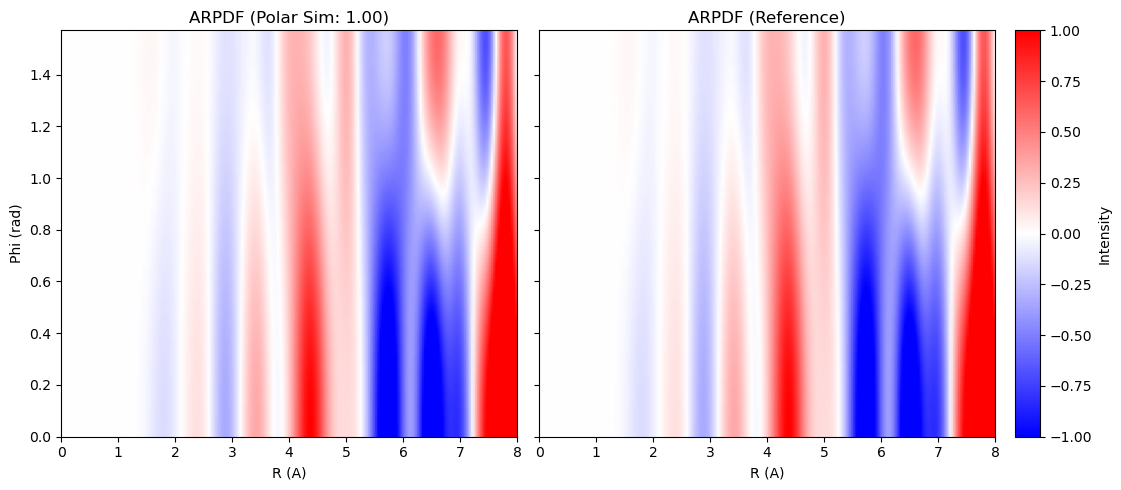

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
polar_model = ARPDFPolarModel(
    R, Phi, np.unique(u1.atoms.types), cutoff=9.0, sigma0=0.2, field_batch_size=512
).to(device)
selected_pos1, around_pos1, center_masses, atom_pairs = get_atoms_pos(u1, modified_atoms, cutoff=11.0, periodic=True)
selected_pos2 = u2.atoms.positions[modified_atoms]
polar_model.set_system(around_pos1, atom_pairs, polar_axis)
selected_pos1 = toTensor(selected_pos1, device=device).float()
selected_pos2 = toTensor(selected_pos2, device=device).float()
image0 = polar_model(selected_pos1)
image1 = polar_model(selected_pos2)
ARPDF2 = (image1 - image0).cpu().numpy()
_ = compare_ARPDF_polar(ARPDF2, ARPDF, (R, Phi), sim_name="Polar Sim", show_range=8.0, weight_cutoff=5.0)

In [4]:
%timeit _ = polar_model(selected_pos2)

3.38 ms ± 28.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
